<a href="https://colab.research.google.com/github/arvinth777/FALCON/blob/main/ML_Brain_Tumor_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("GPU detected:", tf.config.list_physical_devices('GPU'))

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install -q kaggle xgboost opencv-python

In [ ]:
# move token into the right place
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset zip
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

# unzip into /content/data
!unzip -q brain-tumor-detection.zip -d /content/data
!find /content/data -maxdepth 2 -type d -print

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
  0% 0.00/84.0M [00:00<?, ?B/s]
100% 84.0M/84.0M [00:00<00:00, 1.70GB/s]
/content/data
/content/data/Br35H-Mask-RCNN
/content/data/Br35H-Mask-RCNN/TRAIN
/content/data/Br35H-Mask-RCNN/TEST
/content/data/Br35H-Mask-RCNN/VAL
/content/data/yes
/content/data/pred
/content/data/no


In [ ]:
import os, glob, cv2
base = "/content/data/Br35H-Mask-RCNN"
classes = sorted([d for d in os.listdir(base) if os.path.isdir(os.path.join(base,d))])
counts = {c: len(glob.glob(os.path.join(base, c, "*"))) for c in classes}
classes, counts

(['TEST', 'TRAIN', 'VAL'], {'TEST': 101, 'TRAIN': 501, 'VAL': 202})

In [ ]:
import os, glob, cv2

# point to the train split that already has class folders inside
base = "/content/data/Br35H-Mask-RCNN/TRAIN"

# we want only 'yes' and 'no' (some zips include extra dirs)
classes = [c for c in ("no","yes") if os.path.isdir(os.path.join(base, c))]
counts = {c: len(glob.glob(os.path.join(base, c, "*.*"))) for c in classes}
classes, counts

([], {})

In [ ]:
!ls -R /content/data

/content/data:
Br35H-Mask-RCNN  no  pred  yes

/content/data/Br35H-Mask-RCNN:
annotations_all.json  TEST  TRAIN  VAL

/content/data/Br35H-Mask-RCNN/TEST:
annotations_test.json  y717.jpg  y734.jpg  y751.jpg  y768.jpg  y785.jpg
y701.jpg	       y718.jpg  y735.jpg  y752.jpg  y769.jpg  y786.jpg
y702.jpg	       y719.jpg  y736.jpg  y753.jpg  y770.jpg  y787.jpg
y703.jpg	       y720.jpg  y737.jpg  y754.jpg  y771.jpg  y788.jpg
y704.jpg	       y721.jpg  y738.jpg  y755.jpg  y772.jpg  y789.jpg
y705.jpg	       y722.jpg  y739.jpg  y756.jpg  y773.jpg  y790.jpg
y706.jpg	       y723.jpg  y740.jpg  y757.jpg  y774.jpg  y791.jpg
y707.jpg	       y724.jpg  y741.jpg  y758.jpg  y775.jpg  y792.jpg
y708.jpg	       y725.jpg  y742.jpg  y759.jpg  y776.jpg  y793.jpg
y709.jpg	       y726.jpg  y743.jpg  y760.jpg  y777.jpg  y794.jpg
y710.jpg	       y727.jpg  y744.jpg  y761.jpg  y778.jpg  y795.jpg
y711.jpg	       y728.jpg  y745.jpg  y762.jpg  y779.jpg  y796.jpg
y712.jpg	       y729.jpg  y746.jpg  y763.jpg  y780.jpg  y79

In [ ]:
import os, glob, cv2

base = "/content/data"

# pick the actual class folders that exist (case-insensitive match for safety)
all_dirs = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
classes = [d for d in all_dirs if d.lower() in ("yes","no")]

# counts
counts = {c: len(glob.glob(os.path.join(base, c, "*.*"))) for c in classes}
classes, counts

(['yes', 'no'], {'yes': 1500, 'no': 1500})

In [ ]:
import numpy as np, os, glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
base = "/content/data"
classes = ['yes','no']   # order doesn‚Äôt matter
paths, labels = [], []

In [ ]:
cap_per_class = 1500


In [ ]:
for i, c in enumerate(classes):
    files = sorted(glob.glob(os.path.join(base, c, "*.*")))[:cap_per_class]
    paths += files
    labels += [i]*len(files)

labels = np.array(labels)

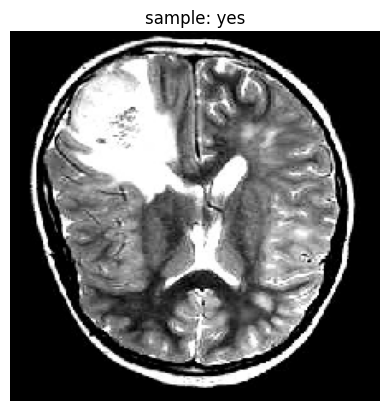

In [ ]:
img0 = image.load_img(paths[0], target_size=(224,224))
plt.imshow(img0); plt.title(f"sample: {classes[labels[0]]}"); plt.axis('off'); plt.show()


In [ ]:
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")


94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


In [ ]:
def extract(p):
    img = image.load_img(p, target_size=(224,224))
    x = image.img_to_array(img)[None,...]
    x = preprocess_input(x)
    return model.predict(x, verbose=0)[0]


In [ ]:
X = np.vstack([extract(p) for p in paths])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, stratify=labels, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train.shape, X_test.shape

((2400, 2048), (600, 2048))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd, numpy as np, time, warnings

results = []
y_proba_xgb = None # Initialize the variable

def eval_model(name, clf, X_train, y_train, X_test, y_test, probas=True):
    t0 = time.time()
    print(f"‚ñ∂Ô∏è Training {name} ...", end="")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    auc = np.nan # Initialize auc

    if probas and hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        # Store y_proba for XGBoost in the global variable
        if name == "XGBoost (fast)":
            global y_proba_xgb
            y_proba_xgb = y_proba
    elif probas and hasattr(clf, "decision_function"): # For LinearSVC
         y_score = clf.decision_function(X_test)
         # CalibratedClassifierCV wraps the estimator, so it should have predict_proba
         # but adding this for robustness
         if name == "Linear SVM (calibrated)":
             # Note: CalibratedClassifierCV should have predict_proba,
             # if not, you might need to handle its output differently
             pass # Let the predict_proba block handle it

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
    print(f" done in {time.time()-t0:.1f}s  acc={acc:.3f}")
    results.append([name, acc, prec, rec, f1, auc])

# FAST configs to avoid long runtimes
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, solver="lbfgs")),
    ("KNN (k=5)", KNeighborsClassifier(n_neighbors=5)),
    # Use Linear SVM instead of RBF; calibrate to get probabilities/AUC
    ("Linear SVM (calibrated)", CalibratedClassifierCV(
        estimator=LinearSVC(dual=False, max_iter=2000), cv=3)),
    ("Naive Bayes (Gaussian)", GaussianNB()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42, max_depth=12)),
    ("Random Forest", RandomForestClassifier(n_estimators=200, random_state=42)),
    ("XGBoost (fast)", XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9,
        colsample_bytree=0.9, tree_method="hist", eval_metric="logloss",
        random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42)),
    ("MLP", MLPClassifier(hidden_layer_sizes=(128,64), activation="relu", max_iter=120, random_state=42)),
]

for name, clf in models:
    eval_model(name, clf, X_train, y_train, X_test, y_test, probas=True)

df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC"])\
        .sort_values("Accuracy", ascending=False).reset_index(drop=True)
df

‚ñ∂Ô∏è Training Logistic Regression ... done in 0.5s  acc=0.985
‚ñ∂Ô∏è Training KNN (k=5) ... done in 0.5s  acc=0.982
‚ñ∂Ô∏è Training Linear SVM (calibrated) ... done in 1.6s  acc=0.987
‚ñ∂Ô∏è Training Naive Bayes (Gaussian) ... done in 0.1s  acc=0.915
‚ñ∂Ô∏è Training Decision Tree ... done in 6.3s  acc=0.887
‚ñ∂Ô∏è Training Random Forest ... done in 20.1s  acc=0.973
‚ñ∂Ô∏è Training XGBoost (fast) ... done in 38.2s  acc=0.982
‚ñ∂Ô∏è Training AdaBoost ... done in 148.7s  acc=0.950
‚ñ∂Ô∏è Training MLP ... done in 1.8s  acc=0.985


Model  Accuracy  Precision    Recall        F1   ROC_AUC
0  Linear SVM (calibrated)  0.986667   1.000000  0.973333  0.986486  0.997744
1      Logistic Regression  0.985000   0.993220  0.976667  0.984874  0.997600
2                      MLP  0.985000   0.993220  0.976667  0.984874  0.998411
3           XGBoost (fast)  0.981667   0.993174  0.970000  0.981450  0.998256
4                KNN (k=5)  0.981667   0.976898  0.986667  0.981758  0.995383
5            Random Forest  0.973333   0.982993  0.963333  0.973064  0.998572
6                 AdaBoost  0.950000   0.962329  0.936667  0.949324  0.991567
7   Naive Bayes (Gaussian)  0.915000   0.902913  0.930000  0.916256  0.942222
8            Decision Tree  0.886667   0.884106  0.890000  0.887043  0.847117

In [ ]:
!apt-get install -y build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
!pip install cython numpy

In [ ]:
!pip -q install "pomegranate==0.14.8"

  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  √ó Getting requirements to build wheel did not run successfully.
  ‚îÇ exit code: 1
  ‚ï∞‚îÄ> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

√ó Getting requirements to build wheel did not run successfully.
‚îÇ exit code: 1
‚ï∞‚îÄ> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# ===== Proper BN: TAN with pgmpy (compatible with your version) =====
!pip -q install pgmpy

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

from pgmpy.estimators import TreeSearch, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import DiscreteBayesianNetwork  # <-- Use DiscreteBayesianNetwork

# guard results if needed
try:
    results  # noqa
except NameError:
    results = []

# 1) PCA to keep BN tractable
pca = PCA(n_components=20, random_state=42)
Z_train = pca.fit_transform(X_train)
Z_test  = pca.transform(X_test)

# 2) Discretize
kb = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
Zd_train = kb.fit_transform(Z_train).astype(int)
Zd_test  = kb.transform(Z_test).astype(int)

# 3) DataFrames with class Y and features F0..F19
feat_cols = [f"F{i}" for i in range(Zd_train.shape[1])]
df_train = pd.DataFrame(Zd_train, columns=feat_cols)
df_train.insert(0, "Y", y_train.astype(int))

df_test = pd.DataFrame(Zd_test, columns=feat_cols)
df_test.insert(0, "Y", y_test.astype(int))

# 4) Learn TAN structure (returns a DAG in your pgmpy)
ts = TreeSearch(df_train)
tan_dag = ts.estimate(estimator_type="tan", class_node="Y")  # DAG

# 5) Convert DAG -> DiscreteBayesianNetwork and fit CPDs
model = DiscreteBayesianNetwork(tan_dag.edges())
model.fit(df_train, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=1)

# 6) Inference with VariableElimination (row-wise; ~600 rows is fine)
infer = VariableElimination(model)
X_only = df_test.drop(columns=["Y"])

def p_y1(row):
    evidence = {col: int(row[col]) for col in X_only.columns}
    q = infer.query(variables=["Y"], evidence=evidence, show_progress=False)
    # q.values is [P(Y=0), P(Y=1)]
    return float(q.values[1])

y_proba_bn = np.array([p_y1(r) for _, r in X_only.iterrows()])
y_pred_bn  = (y_proba_bn >= 0.5).astype(int)

# 7) Metrics
acc = accuracy_score(y_test, y_pred_bn)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_bn, average="binary")
auc = roc_auc_score(y_test, y_proba_bn)
print(f"TAN Bayesian Network  acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}  auc={auc:.3f}")

# 8) Add to results table
results.append(["Bayesian Network (TAN, PCA20)", acc, prec, rec, f1, auc])
df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC"])\
        .sort_values("Accuracy", ascending=False).reset_index(drop=True)
df

Building tree:   0%|          | 0/210.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/210.0 [00:00<?, ?it/s]

TAN Bayesian Network  acc=0.888  prec=0.906  rec=0.867  f1=0.886  auc=0.943


Model  Accuracy  Precision    Recall        F1  \
0        Linear SVM (calibrated)  0.986667   1.000000  0.973333  0.986486   
1            Logistic Regression  0.985000   0.993220  0.976667  0.984874   
2                            MLP  0.985000   0.993220  0.976667  0.984874   
3                      KNN (k=5)  0.981667   0.976898  0.986667  0.981758   
4                 XGBoost (fast)  0.981667   0.993174  0.970000  0.981450   
5                  Random Forest  0.973333   0.982993  0.963333  0.973064   
6                       AdaBoost  0.950000   0.962329  0.936667  0.949324   
7         Naive Bayes (Gaussian)  0.915000   0.902913  0.930000  0.916256   
8  Bayesian Network (TAN, PCA20)  0.888333   0.905923  0.866667  0.885860   
9                  Decision Tree  0.886667   0.884106  0.890000  0.887043   

    ROC_AUC  
0  0.997744  
1  0.997600  
2  0.998411  
3  0.995383  
4  0.998256  
5  0.998572  
6  0.991567  
7  0.942222  
8  0.942722  
9  0.847117

from matplotlib import pyplot as plt
df['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['F1'].plot(kind='hist', bins=20, title='F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Recall', y='F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='F1', y='ROC_AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['F1'].plot(kind='line', figsize=(8, 4), title='F1')
plt.gca().spines[['top', 'right']].set_visible(False)

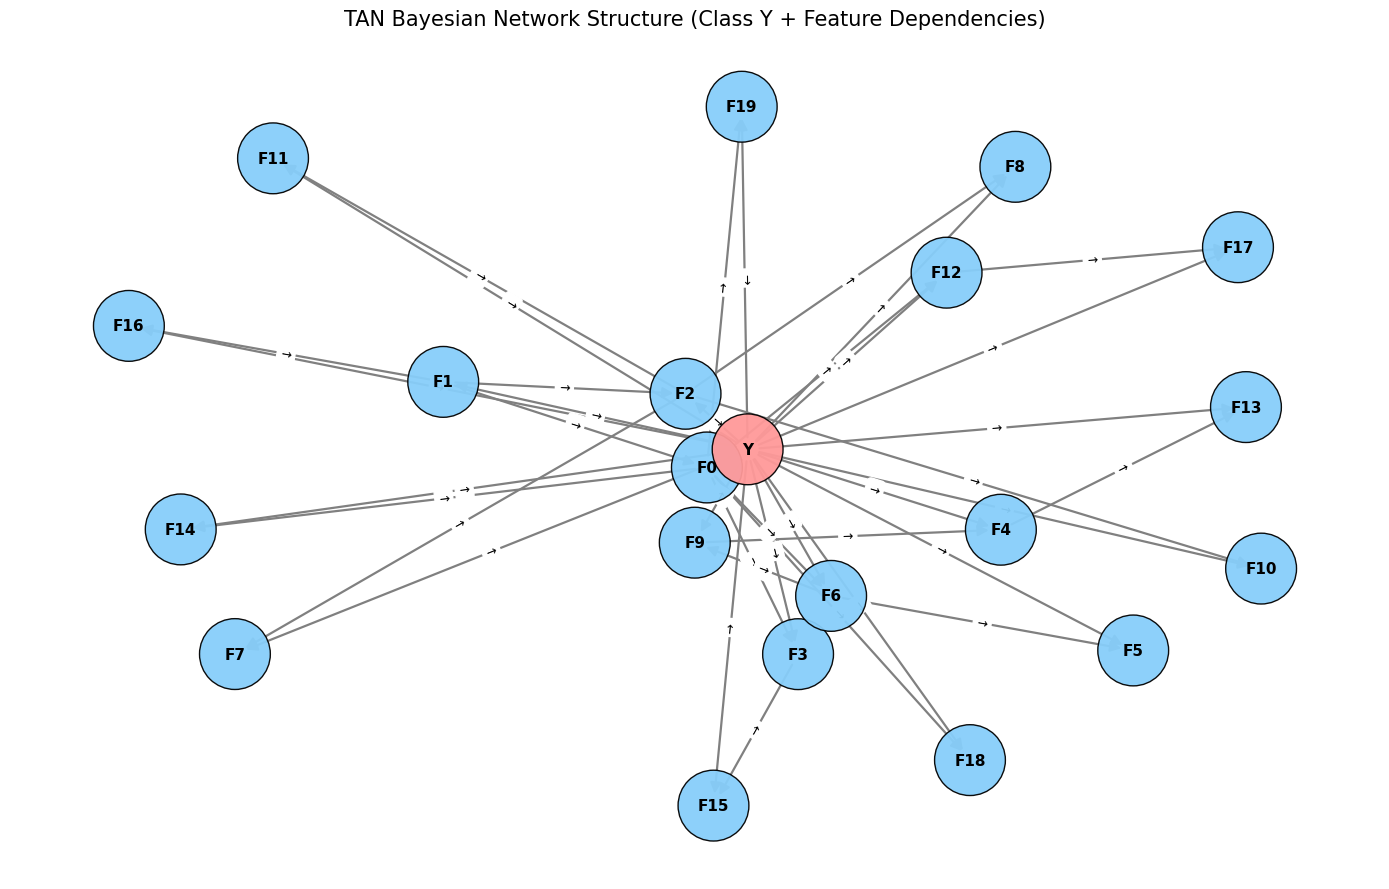

Saved to /content/TAN_BN_structure.png


In [ ]:
# üîé TAN graph with edge labels + PNG export
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(model.edges())  # model from your TAN cell

# color class vs features
node_colors = ["#ff9999" if n == "Y" else "#87cefa" for n in G.nodes()]
pos = nx.spring_layout(G, seed=42, k=0.6)

plt.figure(figsize=(14,9))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2600,
                       edgecolors="black", linewidths=1.0, alpha=0.95)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=16,
                       edge_color="gray", width=1.6)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

# add simple edge labels like "‚Üí"
edge_labels = {e: "‚Üí" for e in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("TAN Bayesian Network Structure (Class Y + Feature Dependencies)", fontsize=15)
plt.axis("off")


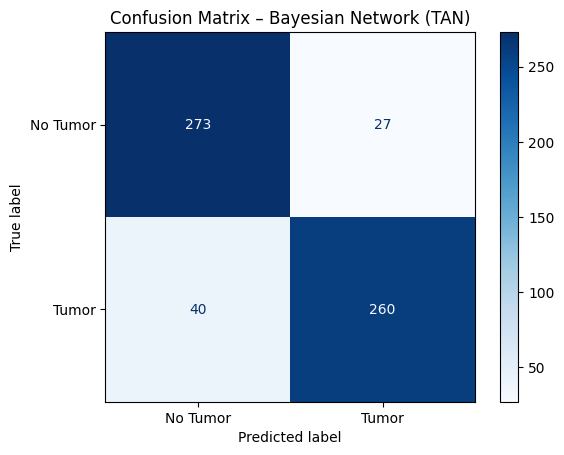

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix for the TAN Bayesian Network
cm = confusion_matrix(y_test, y_pred_bn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Tumor", "Tumor"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix ‚Äì Bayesian Network (TAN)")
plt.show()

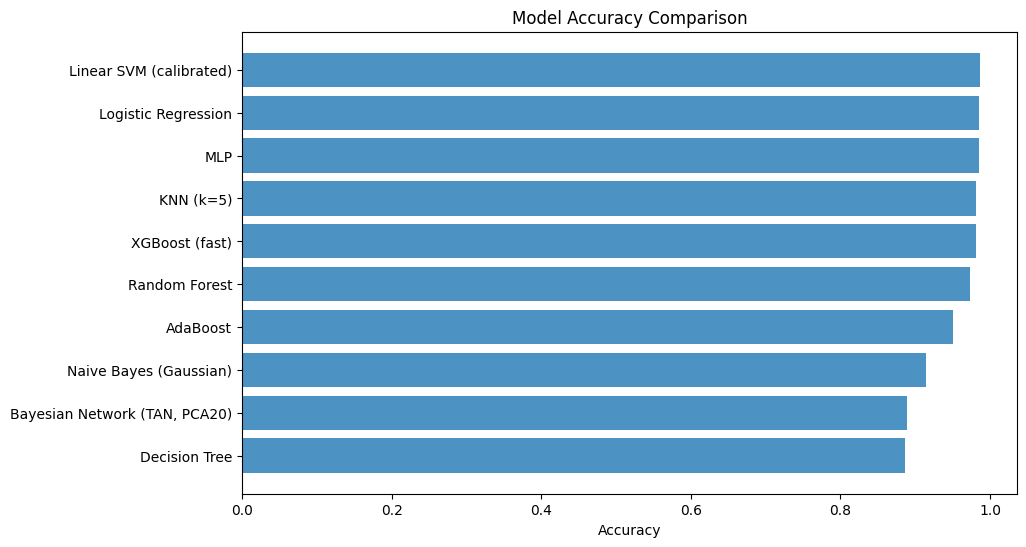

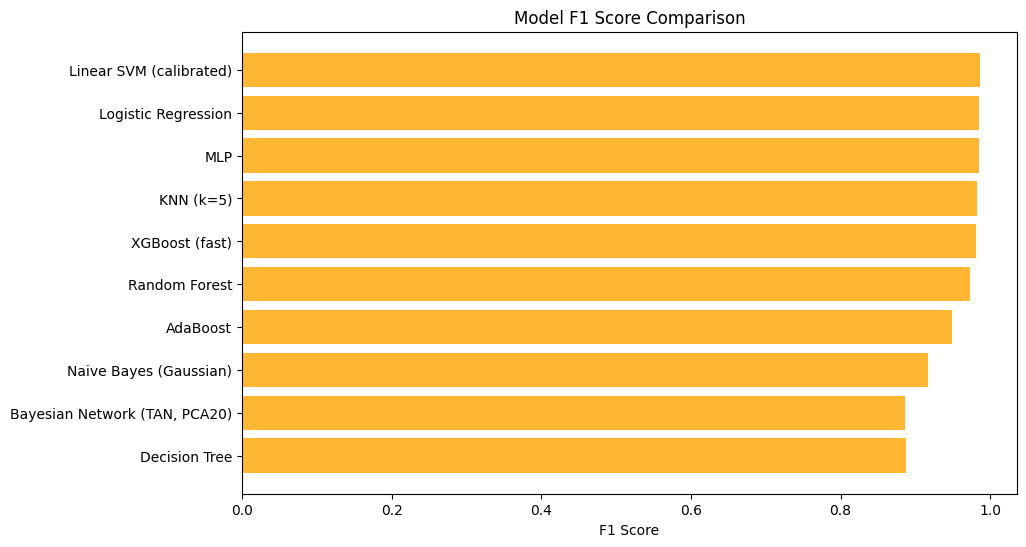

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df["Model"], df["Accuracy"], alpha=0.8)
plt.gca().invert_yaxis()
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

plt.figure(figsize=(10,6))
plt.barh(df["Model"], df["F1"], alpha=0.8, color="orange")
plt.gca().invert_yaxis()
plt.xlabel("F1 Score")
plt.title("Model F1 Score Comparison")
plt.show()

In [ ]:
from scipy.stats import ttest_ind
import itertools

pairs = list(itertools.combinations(df["Model"], 2))
for a, b in pairs:
    m1 = df.loc[df["Model"]==a, "Accuracy"].values[0]
    m2 = df.loc[df["Model"]==b, "Accuracy"].values[0]
    print(f"{a} vs {b}: Œî={abs(m1-m2):.4f}")

Linear SVM (calibrated) vs Logistic Regression: Œî=0.0017
Linear SVM (calibrated) vs MLP: Œî=0.0017
Linear SVM (calibrated) vs KNN (k=5): Œî=0.0050
Linear SVM (calibrated) vs XGBoost (fast): Œî=0.0050
Linear SVM (calibrated) vs Random Forest: Œî=0.0133
Linear SVM (calibrated) vs AdaBoost: Œî=0.0367
Linear SVM (calibrated) vs Naive Bayes (Gaussian): Œî=0.0717
Linear SVM (calibrated) vs Bayesian Network (TAN, PCA20): Œî=0.0983
Linear SVM (calibrated) vs Decision Tree: Œî=0.1000
Logistic Regression vs MLP: Œî=0.0000
Logistic Regression vs KNN (k=5): Œî=0.0033
Logistic Regression vs XGBoost (fast): Œî=0.0033
Logistic Regression vs Random Forest: Œî=0.0117
Logistic Regression vs AdaBoost: Œî=0.0350
Logistic Regression vs Naive Bayes (Gaussian): Œî=0.0700
Logistic Regression vs Bayesian Network (TAN, PCA20): Œî=0.0967
Logistic Regression vs Decision Tree: Œî=0.0983
MLP vs KNN (k=5): Œî=0.0033
MLP vs XGBoost (fast): Œî=0.0033
MLP vs Random Forest: Œî=0.0117
MLP vs AdaBoost: Œî=0.0350
MLP vs N

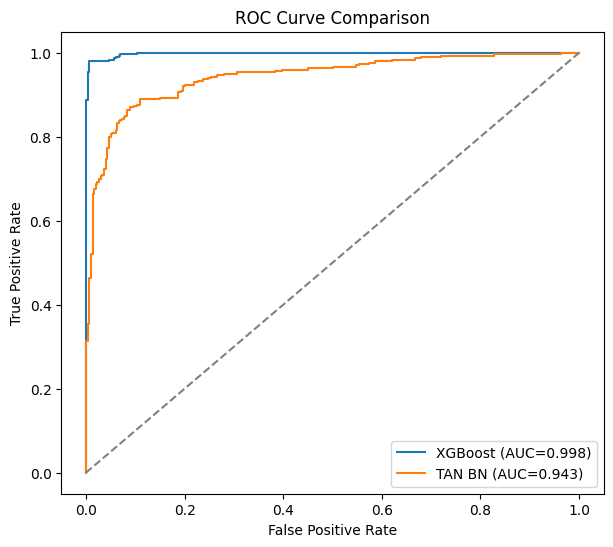

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
for name, y_proba, y_true in [("XGBoost", y_proba_xgb, y_test),
                              ("TAN BN", y_proba_bn, y_test)]:
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(); plt.show()